# Student Project: Detecting Acute Strokes with AI

This Jupyter notebook presents a student project conducted at the University of Mannheim, focused on detecting acute strokes using artificial intelligence (AI) techniques. The project involves the analysis of CT scans and the application of a neural model to predict the likelihood of various stroke types, including no stroke, hemorrhage, and ischemic stroke. 

### Dataset and Preprocessing

The project utilizes a dataset consisting of CT scans of patients with suspected acute strokes. These scans undergo preprocessing steps, including windowing techniques to enhance the relevant features for stroke detection.

### Neural Model for Stroke Classification

A neural model is trained to classify the CT scans into different stroke categories. The model leverages deep learning techniques to learn and identify patterns associated with different stroke types. 

### Interpreting Model Decisions with LIME

To provide insights into the neural model's decision-making process, the Local Interpretable Model-Agnostic Explanations (LIME) technique is employed. LIME allows us to explain the model's predictions at the local level, highlighting the important image regions that contribute to the stroke classification decision.

### Uncertainty Estimation with Monte Carlo Sampling

In addition to the stroke classification, this project also focuses on estimating the uncertainty associated with the model's predictions. Monte Carlo sampling is applied to the model, and multiple runs with different dropout configurations are used to measure uncertainty. The resulting uncertainty metrics provide valuable information about the model's confidence in its predictions.

### Experimental Analysis and Results

The notebook presents an experimental analysis of the trained model, including evaluations of its classification performance, LIME explanations, and uncertainty measurements. The results are visualized and interpreted to gain insights into the model's performance and its ability to detect acute strokes accurately.



In [9]:
import pydicom
import numpy as np

import os
import uuid
from flask import Flask, request, jsonify
from flask_cors import CORS
import pandas as pd
import os
import seaborn as sns
import tensorflow as tf
import joblib
from api_AI import *
from Utilities.db_functions import *
from Utilities.xai_functions import *
import torch
from skimage import img_as_float
import copy

from scipy.ndimage import binary_erosion, binary_dilation

from scipy.ndimage import label
from skimage.measure import regionprops
from scipy.ndimage import binary_fill_holes
import concurrent.futures


## Model Loading

In [3]:
model_torch = torch.load('../stroke-backend/New_models/torch_test/efficientnet_v2_l.ckpt', map_location='cpu')
model_torch = torch.load('../stroke-backend/New_models/torch_test/vit_l_16.ckpt', map_location='cpu')

# The path for the Model we want to use for the investigation

## CT Scan Import

In [4]:
file = "org.dcm"
# The path for the DICOM file we want to investigate

## Prediction

shape: (512, 512), type: <class 'numpy.float64'>


Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


No Stroke Standard Deviation : 0.0267
Ischemic Deviation           : 0.0683
Hemorrhage Deviation         : 0.9050


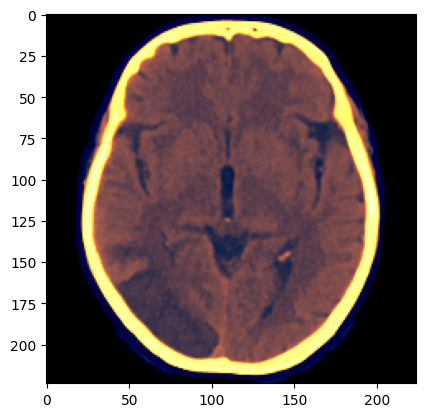

In [5]:
# Preprocess the DICOM file using windowing
dicom_preprocess, data = apply_windowing(file)

# Convert data to a NumPy array and set the data type to float32
data = np.array(data).astype(np.float32)

# Display the image using matplotlib
imgplot = plt.imshow(data)

# Convert the data to a Torch tensor and move the axis to match the expected input shape of the model
data_torch = torch.from_numpy(np.expand_dims(np.moveaxis(data, -1, 0), axis=0)).to('cpu')

# Apply softmax to the predictions of the model
m = nn.Softmax()
prediction_torch = m(model_torch(data_torch))

# Convert the predictions from Torch tensor to NumPy array
prediction_numpy = prediction_torch.detach().numpy()

# Print the standard deviation for each prediction category
print("No Stroke Standard Deviation : {:.4f}".format(prediction_numpy[0][0]))
print("Ischemic Deviation           : {:.4f}".format(prediction_numpy[0][1]))
print("Hemorrhage Deviation         : {:.4f}".format(prediction_numpy[0][2]))


## Explanation - LIME

Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


40


100%|██████████| 64/64 [00:32<00:00,  1.98it/s] 
Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


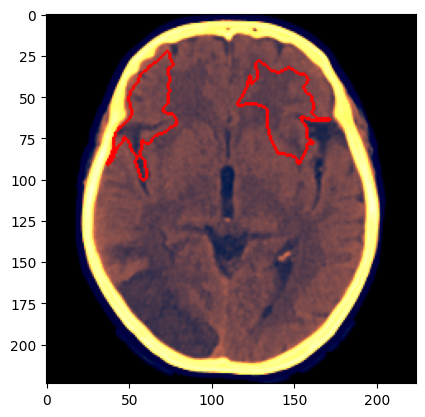

In [11]:
def remove_noise(binary_array, erosion_iterations=2, dilation_iterations=1):
    """
    Removes noise from a binary array using erosion and dilation operations.

    Args:
        binary_array (ndarray): Input binary array containing foreground and background pixels.
        erosion_iterations (int): Number of iterations for the erosion operation (default: 2).
        dilation_iterations (int): Number of iterations for the dilation operation (default: 1).

    Returns:
        ndarray: The binary array with noise removed.

    """
    # Perform erosion to remove small foreground regions
    eroded_array = binary_erosion(binary_array, iterations=erosion_iterations)
    
    # Perform dilation to restore the remaining foreground regions
    dilated_array = binary_dilation(eroded_array, iterations=dilation_iterations)
    
    return dilated_array

def remove_small_regions(binary_array, min_size=100):
    """
    Removes small regions from a binary array based on a minimum size threshold.

    Args:
        binary_array (ndarray): Input binary array containing foreground and background pixels.
        min_size (int): Minimum size threshold for region filtering (default: 100).

    Returns:
        ndarray: The binary array with small regions removed.

    """
    # Label connected regions in the binary array
    labeled_array, num_labels = label(binary_array)
    
    # Get properties of each labeled region
    region_props = regionprops(labeled_array)
    
    # Create an empty array for the output
    filtered_array = np.zeros_like(binary_array, dtype=bool)
    
    # Iterate over the regions and filter based on size
    for region in region_props:
        if region.area >= min_size:
            filtered_array[labeled_array == region.label] = True
    
    return filtered_array

def create_segmentation_mask(img):
    """
    Creates a segmentation mask from an image by removing the background, bone, noise, and small regions.

    Args:
        img (ndarray): Input image.

    Returns:
        ndarray: The segmentation mask.

    """

    mask = np.full((img.shape[0], img.shape[1]), False, dtype=bool)
    #removes background and bone
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i][j][0] != 0 and img[i][j][1] != 0:
                if img[i][j][0] != 1 and img[i][j][1] != 1:
                    mask[i][j] = True

    #removes noise
    mask = remove_noise(mask)
    #removes additional small noisy regions
    mask = remove_small_regions(mask, min_size=200)
    #removes small areas inside positive regions
    final_mask = binary_fill_holes(mask)

    return final_mask

import multiprocessing


class ImageExplanation(object):
    def __init__(self, image, segments):
        """Init function.
        Args:
            image: 3d numpy array
            segments: 2d numpy array, with the output from skimage.segmentation
        """
        if torch.is_tensor(image):
            self.image = np.moveaxis(image.numpy(), 0, -1)
        else:
            self.image = image
        self.segments = segments
        self.intercept = {}
        self.local_exp = {}
        self.local_pred = {}
        self.score = {}

    def get_image_and_mask(self, label, positive_only=True, negative_only=False, hide_rest=False,
                           num_features=5, min_weight=0.):
        """Init function.
        Args:
            label: label to explain
            positive_only: if True, only take superpixels that positively contribute to
                the prediction of the label.
            negative_only: if True, only take superpixels that negatively contribute to
                the prediction of the label. If false, and so is positive_only, then both
                negativey and positively contributions will be taken.
                Both can't be True at the same time
            hide_rest: if True, make the non-explanation part of the return
                image gray
            num_features: number of superpixels to include in explanation
            min_weight: minimum weight of the superpixels to include in explanation
        Returns:
            (image, mask), where image is a 3d numpy array and mask is a 2d
            numpy array that can be used with
            skimage.segmentation.mark_boundaries
        """
        if label not in self.local_exp:
            raise KeyError('Label not in explanation')
        if positive_only & negative_only:
            raise ValueError("Positive_only and negative_only cannot be true at the same time.")
        segments = self.segments
        image = self.image
        exp = self.local_exp[label]
        mask = np.zeros(segments.shape, segments.dtype)
        if hide_rest:
            temp = np.zeros(self.image.shape)
        else:
            temp = self.image.copy()
        if positive_only:
            fs = [x[0] for x in exp
                  if x[1] > 0 and x[1] > min_weight][:num_features]
        if negative_only:
            fs = [x[0] for x in exp
                  if x[1] < 0 and abs(x[1]) > min_weight][:num_features]
        if positive_only or negative_only:
            for f in fs:
                if f != 0:
                    temp[segments == f] = image[segments == f].copy()
                    mask[segments == f] = 1
            return temp, mask
        else:
            for f, w in exp[:num_features]:
                if np.abs(w) < min_weight:
                    continue
                c = 0 if w < 0 else 1
                mask[segments == f] = -1 if w < 0 else 1
                temp[segments == f] = image[segments == f].copy()
                temp[segments == f, c] = np.max(image)
            return temp, mask
        


class LimeImageExplainer_torch(object):
    """Explains predictions on Image (i.e. matrix) data.
    For numerical features, perturb them by sampling from a Normal(0,1) and
    doing the inverse operation of mean-centering and scaling, according to the
    means and stds in the training data. For categorical features, perturb by
    sampling according to the training distribution, and making a binary
    feature that is 1 when the value is the same as the instance being
    explained."""

    def __init__(self, kernel_width=.25, kernel=None, verbose=False,
                 feature_selection='auto', random_state=None):
        """Init function.
        Args:
            kernel_width: kernel width for the exponential kernel.
            If None, defaults to sqrt(number of columns) * 0.75.
            kernel: similarity kernel that takes euclidean distances and kernel
                width as input and outputs weights in (0,1). If None, defaults to
                an exponential kernel.
            verbose: if true, print local prediction values from linear model
            feature_selection: feature selection method. can be
                'forward_selection', 'lasso_path', 'none' or 'auto'.
                See function 'explain_instance_with_data' in lime_base.py for
                details on what each of the options does.
            random_state: an integer or numpy.RandomState that will be used to
                generate random numbers. If None, the random state will be
                initialized using the internal numpy seed.
        """
        kernel_width = float(kernel_width)

        if kernel is None:
            def kernel(d, kernel_width):
                return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2))

        kernel_fn = partial(kernel, kernel_width=kernel_width)

        self.random_state = check_random_state(random_state)
        self.feature_selection = feature_selection
        self.base = lime_base.LimeBase(kernel_fn, verbose, random_state=self.random_state)

    def explain_instance(self, image, classifier_fn, labels=(1,),
                         hide_color=None,
                         top_labels=5, num_features=100000, num_samples=1000,
                         batch_size=10,
                         segmentation_fn=None,
                         distance_metric='cosine',
                         model_regressor=None,
                         random_seed=None,
                         progress_bar=True):
        """Generates explanations for a prediction.
        First, we generate neighborhood data by randomly perturbing features
        from the instance (see __data_inverse). We then learn locally weighted
        linear models on this neighborhood data to explain each of the classes
        in an interpretable way (see lime_base.py).
        Args:
            image: 3 dimension RGB image. If this is only two dimensional,
                we will assume it's a grayscale image and call gray2rgb.
            classifier_fn: classifier prediction probability function, which
                takes a numpy array and outputs prediction probabilities.  For
                ScikitClassifiers , this is classifier.predict_proba.
            labels: iterable with labels to be explained.
            hide_color: If not None, will hide superpixels with this color.
                Otherwise, use the mean pixel color of the image.
            top_labels: if not None, ignore labels and produce explanations for
                the K labels with highest prediction probabilities, where K is
                this parameter.
            num_features: maximum number of features present in explanation
            num_samples: size of the neighborhood to learn the linear model
            batch_size: batch size for model predictions
            distance_metric: the distance metric to use for weights.
            model_regressor: sklearn regressor to use in explanation. Defaults
            to Ridge regression in LimeBase. Must have model_regressor.coef_
            and 'sample_weight' as a parameter to model_regressor.fit()
            segmentation_fn: SegmentationAlgorithm, wrapped skimage
            segmentation function
            random_seed: integer used as random seed for the segmentation
                algorithm. If None, a random integer, between 0 and 1000,
                will be generated using the internal random number generator.
            progress_bar: if True, show tqdm progress bar.
        Returns:
            An ImageExplanation object (see lime_image.py) with the corresponding
            explanations.
        """
        if len(image.shape) == 2:
            image = gray2rgb(image)
        if random_seed is None:
            random_seed = self.random_state.randint(0, high=1000)

        if segmentation_fn is None:
            segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=4,
                                                    max_dist=200, ratio=0.2,
                                                    random_seed=random_seed)
    
        segments = segmentation_fn(np.moveaxis(image.cpu().detach().numpy(), 0, -1))
        

        fudged_image = image.numpy().copy()
        fudged_image = np.transpose(fudged_image, (1, 2, 0))
        if hide_color is None:
            for x in np.unique(segments):
                fudged_image[segments == x] = (
                    np.mean(image[segments == x][:, 0]),
                    np.mean(image[segments == x][:, 1]),
                    np.mean(image[segments == x][:, 2]))
        else:
            fudged_image[:] = hide_color
            

        fudged_image = np.moveaxis(fudged_image, 0, -1)

        top = labels

        data, labels = self.data_labels(image, fudged_image, segments,
                                        classifier_fn, num_samples,
                                        batch_size=batch_size,
                                        progress_bar=progress_bar)
        distances = sklearn.metrics.pairwise_distances(
            data,
            data[0].reshape(1, -1),
            metric=distance_metric
        ).ravel()

        ret_exp = ImageExplanation(image, segments)

        if top_labels:
            top = np.argsort(labels[0])[-top_labels:]
            ret_exp.top_labels = list(top)
            ret_exp.top_labels.reverse()

        for label in top:
            (ret_exp.intercept[label],
             ret_exp.local_exp[label],
             ret_exp.score[label],
             ret_exp.local_pred[label]) = self.base.explain_instance_with_data(
                data, labels, distances, label, num_features,
                model_regressor=model_regressor,
                feature_selection=self.feature_selection)
            
        return ret_exp

    def data_labels(self,
                    image,
                    fudged_image,
                    segments,
                    classifier_fn,
                    num_samples,
                    batch_size=10,
                    progress_bar=True):
        """Generates images and predictions in the neighborhood of this image.
        Args:
            image: 3d numpy array, the image
            fudged_image: 3d numpy array, image to replace original image when
                superpixel is turned off
            segments: segmentation of the image
            classifier_fn: function that takes a list of images and returns a
                matrix of prediction probabilities
            num_samples: size of the neighborhood to learn the linear model
            batch_size: classifier_fn will be called on batches of this size.
            progress_bar: if True, show tqdm progress bar.
        Returns:
            A tuple (data, labels), where:
                data: dense num_samples * num_superpixels
                labels: prediction probabilities matrix
        """
        def predict(imgs):
            m = nn.Softmax()
            preds = m(model_torch(torch.squeeze(torch.from_numpy(np.array(imgs)))))
            return preds

        n_features = np.unique(segments).shape[0]
        data = self.random_state.randint(0, 2, num_samples * n_features)\
            .reshape((num_samples, n_features))
        labels = []
        data[0, :] = 1
        imgs = []
        rows = tqdm(data) if progress_bar else data
        for row in rows:
            temp = copy.deepcopy(np.moveaxis(image.cpu().detach().numpy(), 0, -1))
            fudged_image_ = np.transpose(copy.deepcopy(fudged_image), (0,2,1))
            #temp_ = copy.deepcopy(image)
            zeros = np.where(row == 0)[0]
            mask = np.zeros(segments.shape).astype(bool)
            for z in zeros:
                if z != 0:
                    mask[segments == z] = True
            #if num % 2 == 0:
            #    temp[mask] = temp[mask]*[0.2, 0.8, 0.8]#*(fudged_image_[mask].25)
            #else:
            #    temp[mask] = temp[mask]*[1.1, 1.1, 1.1]#*(fudged_image_[mask].25)
            temp[mask] = temp[mask] - ((1/(1+np.exp(-temp[mask]+fudged_image_[mask])))-0.5)*2


            imgs.append(np.transpose(np.array(temp),(2,1,0)))
            if len(imgs) == batch_size:
                num_processes = multiprocessing.cpu_count()
                chunk_size = len(imgs) // num_processes
                chunks = [imgs[i:i+chunk_size] for i in range(0, len(imgs), chunk_size)]

                # Create a thread pool executor
                executor = concurrent.futures.ThreadPoolExecutor(max_workers=num_processes)

                # Submit the predict function to the executor for each chunk
                results = [executor.submit(predict, chunk) for chunk in chunks]

                # Retrieve the results from the executor
                predictions = []
                for future in concurrent.futures.as_completed(results):
                    prediction = future.result()
                    predictions.extend(prediction)

                labels.extend(predictions)
                imgs = []
        if len(imgs) > 0:
            num_processes = multiprocessing.cpu_count()
            chunk_size = len(imgs) // num_processes
            chunks = [imgs[i:i+chunk_size] for i in range(0, len(imgs), chunk_size)]
                
            executor = concurrent.futures.ThreadPoolExecutor(max_workers=num_processes)

                # Submit the predict function to the executor for each chunk
            results = [executor.submit(predict, chunk) for chunk in chunks]

                # Retrieve the results from the executor
            predictions = []
            for future in concurrent.futures.as_completed(results):
                prediction = future.result()
                predictions.extend(prediction)
            labels.extend(predictions)
            
        final_labels = []
        m = nn.Softmax()
        for torch_label in labels:
            final_labels.append(m(torch_label).cpu().detach().numpy())
        
        #print(final_labels)
        return data, np.array(final_labels)
    
from scipy.ndimage.measurements import label
from scipy.spatial.distance import pdist, squareform

def calculate_diameter(binary_array):
    # Label connected components in the binary array
    labeled_array, num_features = label(binary_array)
    
    # Find the labels of the connected components
    labels = np.unique(labeled_array)[1:]  # Exclude background label 0
    
    max_diameter = 0
    
    # Iterate through each label and calculate the diameter
    for label_val in labels:
        # Extract the connected component for the current label
        component = np.where(labeled_array == label_val, 1, 0)
        
        # Find the boundary points of the connected component
        boundary_points = np.argwhere(component == 1)
        
        # Calculate the pairwise distances between the boundary points
        pairwise_distances = pdist(boundary_points, metric='euclidean')
        
        # Find the maximum distance between any two boundary points
        if len(pairwise_distances) > 0:
            max_component_diameter = np.max(pairwise_distances)
            max_diameter = max(max_diameter, max_component_diameter)
    
    return max_diameter

def create_crucial_segmentation_mask(img):
    
    mask = create_segmentation_mask(img)

    final_mask = copy.deepcopy(mask)

    zero_coords = np.where(mask == False)

    _threshold = int(calculate_diameter(mask)*1/5)
    print(_threshold)

    for x, y in np.ndindex(mask.shape):
        # Calculate the distances to the pixels with value 0
        distances = np.sqrt((x - zero_coords[0])**2 + (y - zero_coords[1])**2)
        
        # Check if the minimum distance is greater than the threshold distance
        if np.min(distances) >= _threshold:
            # Change the value of the pixel
            final_mask[x, y] = False

    return final_mask
    

def plotLIME(model, data, prediction, complexity, torch = False):
    """
    Plots the LIME explanation for an ct-scan classification model.

    Args:
        model: The image classification model.
        data (ndarray or torch.Tensor): The input image data.
        prediction (ndarray or torch.Tensor): The prediction of the model for the input image.
        complexity (int): The complexity parameter for LIME.
        torch (bool): Indicates if the model and data are in torch.Tensor format (default: False).

    Returns:
        ndarray: The LIME explanation mask.

    """

    if torch:
        explainer = LimeImageExplainer_torch() 
        m = nn.Softmax()
        prediction = m(prediction).cpu().detach().numpy()
        data_seg = data.detach().numpy()
        data_seg = np.transpose(data_seg, (1, 2, 0))
    else:
        explainer = LimeImageExplainer()        
        data_seg = data
        
    # Create segmentation mask using create_segmentation_mask method
    segmenter = SegmentationAlgorithm('slic', n_segments=16, compactness=10, sigma=2,
                     start_label=1, mask = create_crucial_segmentation_mask(data_seg))
    explanation_1 = explainer.explain_instance(data, 
                                         classifier_fn = model, 
                                         top_labels=5, 
                                         num_features = 64,
                                         batch_size =128,
                                         hide_color=0, # 0 - gray 
                                         num_samples=complexity,
                                         segmentation_fn=segmenter
                                        )
    temp, mask = explanation_1.get_image_and_mask(explanation_1.top_labels[0], 
                                                positive_only=True,
                                                negative_only=False,
                                                num_features=2, 
                                                hide_rest=False)

    lime_res = mark_boundaries(temp, mask, mode = "thick", color = (255,0,0))
    
    imgplot = plt.imshow(lime_res)
    
    return mask

lime_array = plotLIME(model_torch, data_torch[0], prediction_torch, 512, True)

## Uncertainty Quantification

In [18]:
def calculate_uncertainty(model, data, num_samples):
    """
    Calculates the uncertainty of a model's predictions using Quantitative Measures (QM) by applying Monte Carlo (MC) dropout.

    Args:
        model: Model used for uncertainty measurement (QM).
        data: Data for calculating QM.
        num_samples: Number of runs with different dropouts for QM.

    Returns:
        torch.Tensor: The uncertainty in the form of a standard deviation for each model output neuron.

    """
    num_threads = 4

    def process_predictions(model, data, num_samples):
        model_uncertainty = copy.deepcopy(model)
        predictions = []
        for _ in range(num_samples):
            model_uncertainty.apply(lambda module: setattr(module, 'training', True))
            # Forward pass
            output = model_uncertainty(data)
            predictions.append(output)
        return predictions

    batch_size = num_samples // num_threads

    executor = concurrent.futures.ThreadPoolExecutor(max_workers=num_threads)

    # Split the workload among threads and run the process_predictions function concurrently
    futures = [
        executor.submit(process_predictions, model, data, batch_size)
        for _ in range(num_threads)
    ]

    # Wait for all threads to complete
    concurrent.futures.wait(futures)

    # Gather predictions from each thread
    all_predictions = []
    for future in futures:
        all_predictions.extend(future.result())

    # Convert predictions to a tensor
    predictions = torch.stack(all_predictions)

    # Calculate uncertainty by standard deviation
    uncertainty = torch.std(predictions, dim=0, unbiased=False)
    uncertainty_numpy = uncertainty.detach().numpy()
    
    #printing the results
    print("No Stroke Standard Deviation : {:.4f}".format(uncertainty_numpy[0][0]))
    print("Ischemic Deviation           : {:.4f}".format(uncertainty_numpy[0][1]))
    print("Heemorrhage Deviation        : {:.4f}".format(uncertainty_numpy[0][2]))

    # Uncertainty tensor will have the same shape as the model's output
    return uncertainty_numpy

uncertainties = calculate_uncertainty(model_torch, data_torch, 50)

KeyboardInterrupt: 